In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import itertools
import warnings
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

df = pd.read_csv('C:/Users/Yuwanut/Desktop/Master@KU/อ.เทพฤทธิ์/Data/cutoffcovid/no_tourist_foreign_date_sum_n.csv') #อ่านไฟล์

Error fitting ARIMA model with order (4, 0, 0)
Error fitting ARIMA model with order (4, 2, 4)
Error fitting ARIMA model with order (4, 4, 3)
Error fitting ARIMA model with order (4, 4, 4)
Optimal ARIMA order: (2, 0, 1)
AIC:  10.0
BIC:  15.222612188617115
RMSE Test Score: 181,618.12
MAE Test Score: 145,481.46


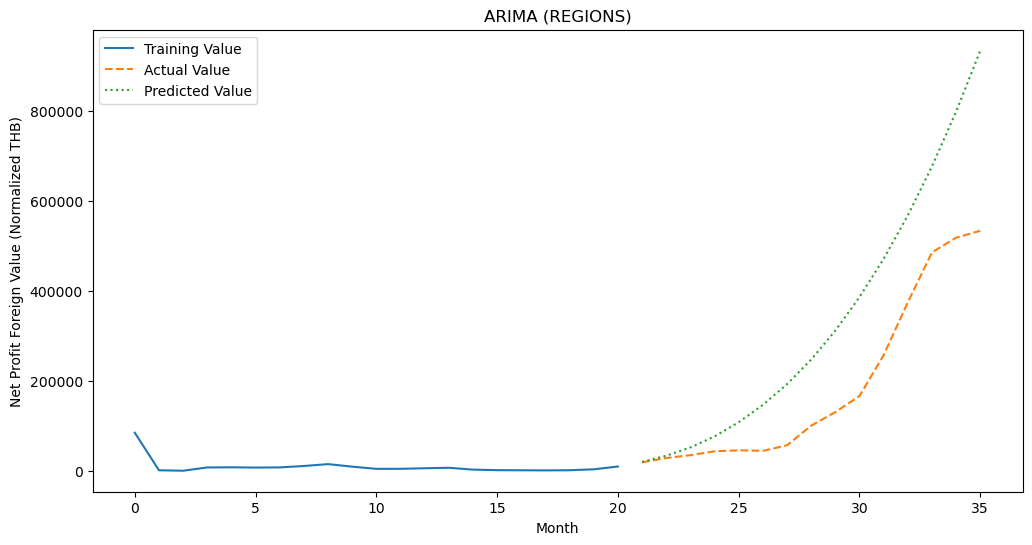

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
RMSE Train Score: 3,816.32
RMSE Test Score: 247,871.51
MAE Train Score: 3,184.74
MAE Test Score: 174,876.19


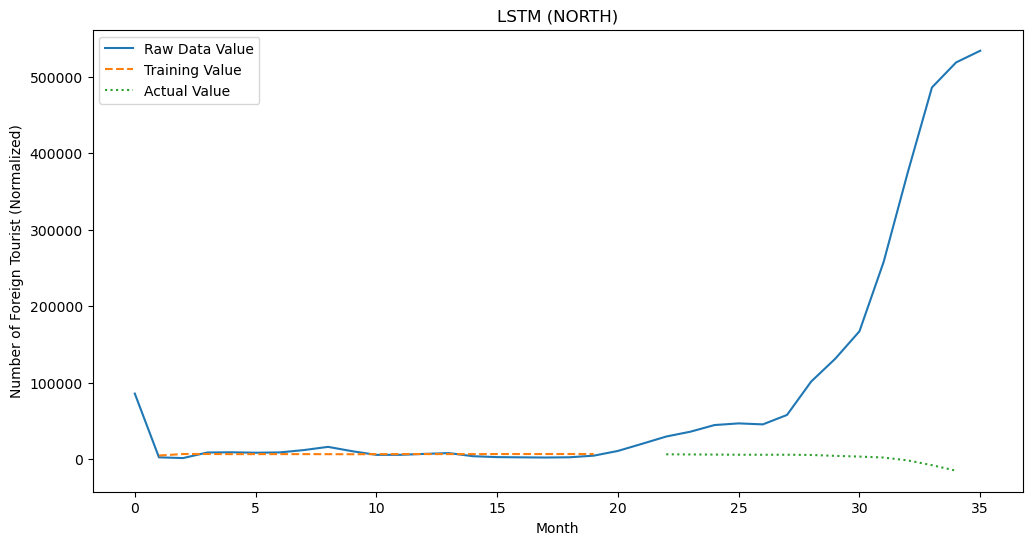

In [12]:
#ARIMA - NORTH

# Ignore warnings
warnings.filterwarnings("ignore")

n_value = df['value']

#divide data into training and testing sets
train_data = n_value[:int(len(n_value) * 0.6)]
test_data = n_value[int(len(n_value) * 0.6):]

#determine optimal arima parameters with grid search
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
pdq_combinations = list(itertools.product(p_values, d_values, q_values))
best_aic = float('inf')
best_order = None
best_model = None

# Iterate through possible parameter combinations
for order in pdq_combinations:
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except Exception as e:
        print(f"Error fitting ARIMA model with order {order}")
print(f"Optimal ARIMA order: {best_order}")
print("AIC: ", best_aic)
print("BIC: ", best_model.bic)

#forecast net foreign with arima model
predictions = model_fit.forecast(steps = len(test_data))

#compute root mean squared error (rmse)
rmse = sqrt(mean_squared_error(test_data, predictions))
print('RMSE Test Score: {:,.2f}'.format(rmse))
mae = mean_absolute_error(test_data, predictions)
print('MAE Test Score: {:,.2f}'.format(mae))

#display actual vs predicted net foreign value
plt.figure(figsize = (12, 6))
plt.plot(train_data, label = 'Training Value')
plt.plot(test_data, label = 'Actual Value', linestyle='--')
plt.plot(test_data.index, predictions, label = 'Predicted Value', linestyle=':')
plt.xlabel('Month')
plt.ylabel('Net Profit Foreign Value (Normalized THB)')
plt.title('ARIMA (REGIONS)')
plt.legend()
plt.show()

#-------------------------------------------------------------

#LSTM - NORTH

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
tf.random.set_seed(12)

# load the dataset
dataframe = df['value']
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1, 1))

# split into train and test sets
train_size = int(len(dataset) * 0.6)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('RMSE Train Score: {:,.2f}'.format(trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('RMSE Test Score: {:,.2f}'.format(testScore))

train_mae = mean_absolute_error(trainY[0], trainPredict[:,0])
print('MAE Train Score: {:,.2f}'.format(train_mae))
test_mae = mean_absolute_error(testY[0], testPredict[:,0])
print('MAE Test Score: {:,.2f}'.format(test_mae))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize = (12, 6))
plt.plot(scaler.inverse_transform(dataset), label = 'Raw Data Value')
plt.plot(trainPredictPlot, label = 'Training Value', linestyle='--')
plt.plot(testPredictPlot, label = 'Actual Value', linestyle=':')
plt.xlabel('Month')
plt.ylabel('Number of Foreign Tourist (Normalized)')
plt.title('LSTM (NORTH)')
plt.legend()
plt.show()

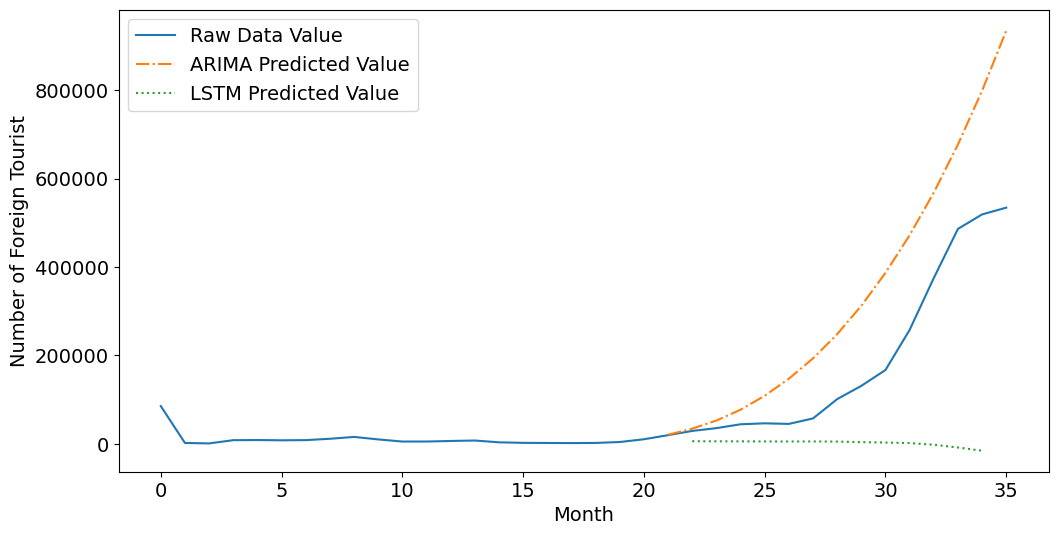

In [13]:
#display actual vs predicted net foreign value
plt.figure(figsize = (12, 6))

plt.plot(scaler.inverse_transform(dataset), label = 'Raw Data Value')
plt.plot(test_data.index, predictions, label = 'ARIMA Predicted Value', linestyle='-.')
plt.plot(testPredictPlot, label = 'LSTM Predicted Value', linestyle=':')

plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Foreign Tourist', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

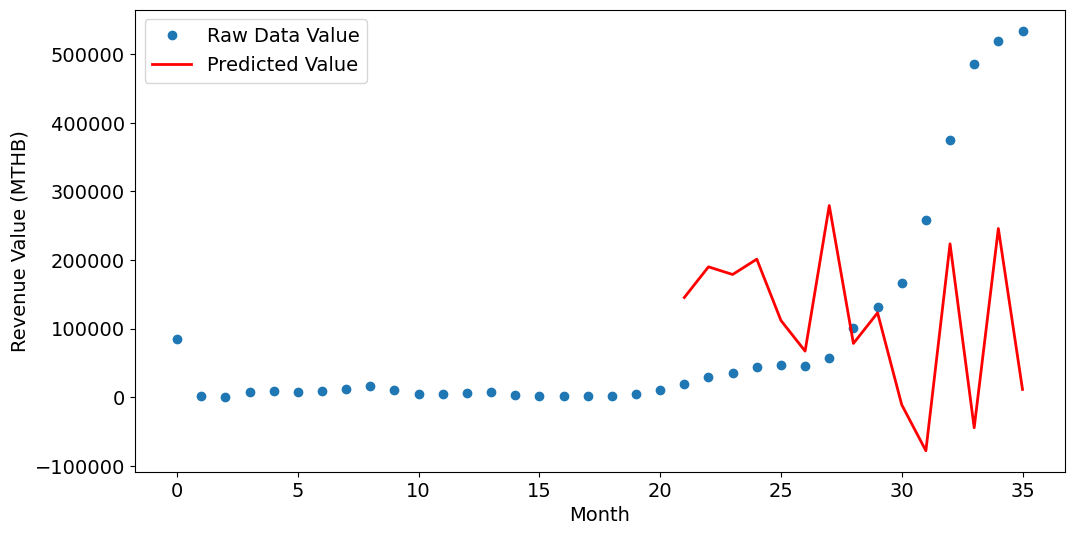

Coefficient: [[11165.13984948]]
Intercept: [-88976.41840075]
Train set accuracy = 0.5428540563013695
Test set accuracy = 0.14496168826799583
RMSE: 112140.26517069769
MSE: 12575439072.554392
Mean is : 85036.13888888889
R-squared: 0.14496168826799583
Mean Absolute Error (MAE): 99566.32023330194
Normalized Mean Absolute Error (NMAE) (หารด้วยค่า range): 0.1867640073179644
NMAE (หารด้วยค่าเฉลี่ย): 1.1708706619828857
85036.13888888889
NRMSE (หารด้วยค่าเฉลี่ย): 1.3187365587850122


In [14]:
# Linear Regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statistics
from sklearn.metrics import r2_score

# Get dataset
df = pd.read_csv('C:/Users/Yuwanut/Desktop/Master@KU/อ.เทพฤทธิ์/Data/cutoffcovid/no_tourist_foreign_date_sum_n.csv') #อ่านไฟล์

df.drop(['date'], axis=1, inplace=True)
df.drop(['region_eng'], axis=1, inplace=True)
df['Time'] = np.arange(len(df.index))

# Describe data
df.describe()

# Splitting variables
X = df['Time'].values.reshape(-1, 1)
y = df['value'].values.reshape(-1, 1)

# Splitting dataset into test/train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 12)

# Regressor model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Prediction result
y_pred_test = regressor.predict(X_test)     # predicted value of y_test
y_pred_train = regressor.predict(X_train)   # predicted value of y_train

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['value'], 'o', label = 'Raw Data Value')           # scatter plot showing actual data
plt.plot(df['Time'].iloc[-len(y_test):], y_pred_test, 'r', linewidth=2, label = 'Predicted Value')   # regression line
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Revenue Value (MTHB)', fontsize = 14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Regressor coefficients and intercept
print(f'Coefficient: {regressor.coef_}')
print(f'Intercept: {regressor.intercept_}')

# Evaluate model's accuracy on train and test set มีค่าใกล้ 1 ยิ่งดี
print("Train set accuracy = " + str(regressor.score(X_train, y_train)))
print("Test set accuracy = " + str(regressor.score(X_test, y_test)))

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {rmse}")

mse = mean_squared_error(y_test, y_pred_test, squared=True)
print(f"MSE: {mse}")

x = statistics.mean(df['value'])

# Printing the mean
print("Mean is :", x)

r2 = r2_score(y_test, y_pred_test)
print(f"R-squared: {r2}")

# คำนวณ MAE ระหว่างค่าจริง (y_test) กับค่าที่โมเดลทำนาย (y_pred)
mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

# คำนวณค่า NMAE (MAE / range ของ y)
y_range = np.max(y) - np.min(y)  # หาค่าช่วงของ y
nmae = mae / y_range
print("Normalized Mean Absolute Error (NMAE) (หารด้วยค่า range):", nmae)

# NMAE โดยหารด้วยค่าเฉลี่ย
mean_of_y = np.mean(y)
nmae_by_mean = mae / mean_of_y
print("NMAE (หารด้วยค่าเฉลี่ย):", nmae_by_mean)
print(mean_of_y)

nrmse_by_mean = rmse / mean_of_y
print("NRMSE (หารด้วยค่าเฉลี่ย):", nrmse_by_mean)

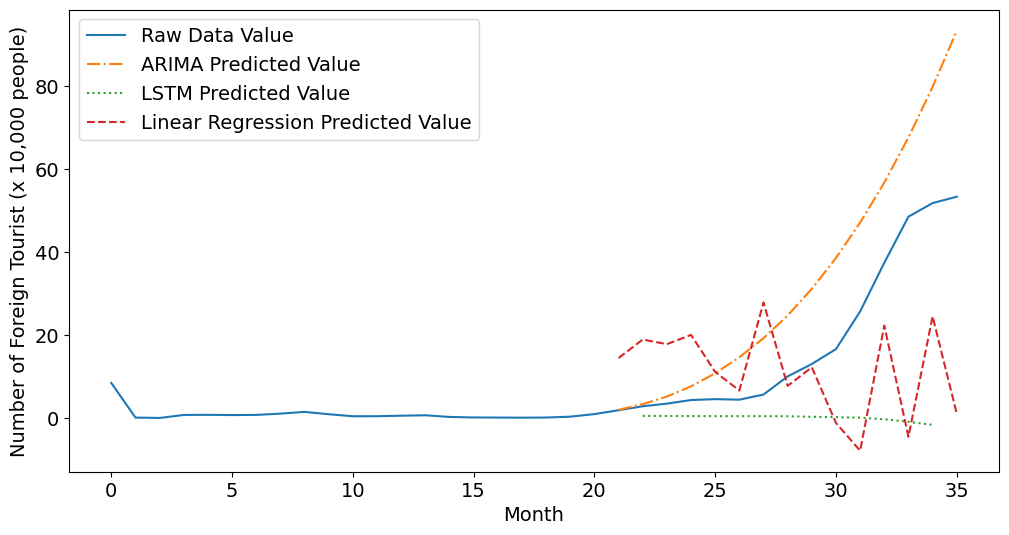

In [15]:
#display actual vs predicted net foreign value
plt.figure(figsize = (12, 6))

plt.plot(scaler.inverse_transform(dataset), label = 'Raw Data Value')
plt.plot(test_data.index, predictions, label = 'ARIMA Predicted Value', linestyle='-.')
plt.plot(testPredictPlot, label = 'LSTM Predicted Value', linestyle=':')
plt.plot(df['Time'].iloc[-len(y_test):], y_pred_test, label = 'Linear Regression Predicted Value', linestyle='--')   # regression line

plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Foreign Tourist (x 10,000 people)', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

y_ticks = plt.gca().get_yticks()  # รับค่า ticks ในแกน y
plt.gca().set_yticklabels([f'{int(tick / 10000)}' for tick in y_ticks])

plt.show()